# Summary

1. Dimensionality reduction of data through PCA
2. Find independent components (that potentially represent activity at different temporal frequencies)
3. Fit regression model for each cell using ICs as predictors as a way to cluster data

In [1]:
import os
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.data as dataUtils

In [2]:
plot_dark = True

sns.set_context('talk')
if plot_dark:
    plt.style.use('dark_background')
#     cmap_rasters = 'inferno'
    cmap_rasters = 'afmhot'
else:
    sns.set_style('white')
    cmap_rasters = 'Greys'

### load data

In [3]:
# options
# expt_id = '190424_f3' # run+feed
# expt_id = '180824_f3r1' # run only
# expt_id = '2019_06_26_fly2'
# expt_id = '2019_06_28_fly2'
expt_id = '2019_06_30_fly1'
# expt_id = '2019_07_01_fly2'

data_dict = dataUtils.load_timeseries(expt_id)

In [4]:
# chose which trials to use (NoneType to default to all)
trial_flags = [1, 2, 3]
if trial_flags is None:
    trial_flags = np.unique(data_dict['trialFlag'])
indxs_flag = np.full(shape=(data_dict['time'].shape[0],), fill_value=False)
for trial_flag in trial_flags:
    indxs_flag |= data_dict['trialFlag'][:, 0] == trial_flag
data_neural = data_dict['dFF'][indxs_flag]
data_ball = data_dict['ball'][indxs_flag]

# preprocess
from scipy import signal
data_neural, A = dataUtils.remove_artifact_cells(data_neural, footprints=data_dict['A'])
data_neural = signal.detrend(data_neural, axis=0)
data_neural = zscore(data_neural)
data_neural = dataUtils.cluster(data_neural)

### preprocess data - split into training/testing sets

In [5]:
# split into train/test trials
trial_len = 100  # length of pseudo-trials in bins
n_trials = np.floor(data_neural.shape[0] / trial_len)
indxs = utils.split_trials(
    n_trials, trials_tr=10, trials_val=2, trials_test=0, trials_gap=0)
data = {}
beh = {}
for dtype in ['train', 'test', 'val']:
    data_segs = []
    beh_segs = []
    for indx in indxs[dtype]:
        ibeg = indx * trial_len
        iend= (indx * trial_len) + trial_len
        # check to see if segment spans multiple trials; if so skip
        if len(np.unique(data_dict['trialFlag'][ibeg:iend])) == 1:
            data_segs.append(data_neural[ibeg:iend])
            beh_segs.append(data_ball[ibeg:iend])
    data[dtype] = data_segs
    beh[dtype] = beh_segs
# for PCA/regression
data['train_all'] = np.concatenate(data['train'], axis=0)
data['val_all'] = np.concatenate(data['val'], axis=0)
beh['train_all'] = np.concatenate(beh['train'], axis=0)
beh['val_all'] = np.concatenate(beh['val'], axis=0)

## 1. Dimensionality reduction with PCA
What is the dimensionality of the data?

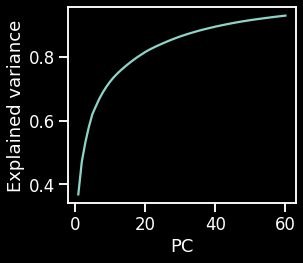

In [6]:
n_components = 60
pca = PCA(n_components=n_components)
pca.fit(data['train_all'])

# plot var explained vs # pcs
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(np.arange(n_components)+1, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('Explained variance')
plt.tight_layout()
plt.show()

### plot data, pca reconstruction, and residual

In [36]:
def plot_reconstruction(data, recon, slc=(0, 5000), n_components=None):

    vmin = np.quantile(data[slice(*slc)], 0.01)
    vmax = np.quantile(data[slice(*slc)], 0.99)
    
    fig = plt.figure(figsize=(12, 12))

    # original data
    plt.subplot(131)
    plt.imshow(
        data[slice(*slc), :].T, aspect='auto', cmap=cmap_rasters, vmin=vmin, vmax=vmax)
    plt.xlim(0, slc[1] - slc[0])
    plt.xlabel('Time')
    plt.ylabel('Neuron')
    plt.title('Original data')

    # reconstruction
    plt.subplot(132)
    plt.imshow(
        recon[slice(*slc), :].T, aspect='auto', cmap=cmap_rasters, vmin=vmin, vmax=vmax)
    plt.xlim(0, slc[1] - slc[0])
    plt.xlabel('Time')
    plt.yticks([])
    if n_components is not None:
        title_str = str('Reconstruction\n(n=%i components)' % n_components)
    else:
        title_str = 'Reconstruction'
    plt.title(title_str)

    # residual
    plt.subplot(133)
    data_res = np.abs(data - recon)
    plt.imshow(
        data_res[slice(*slc), :].T, aspect='auto', cmap=cmap_rasters, 
        vmin=0, vmax=vmax)
    plt.xlim(0, slc[1] - slc[0])
    plt.xlabel('Time')
    plt.yticks([])
    plt.title('Residual')

    plt.tight_layout()
    plt.show()
    return fig

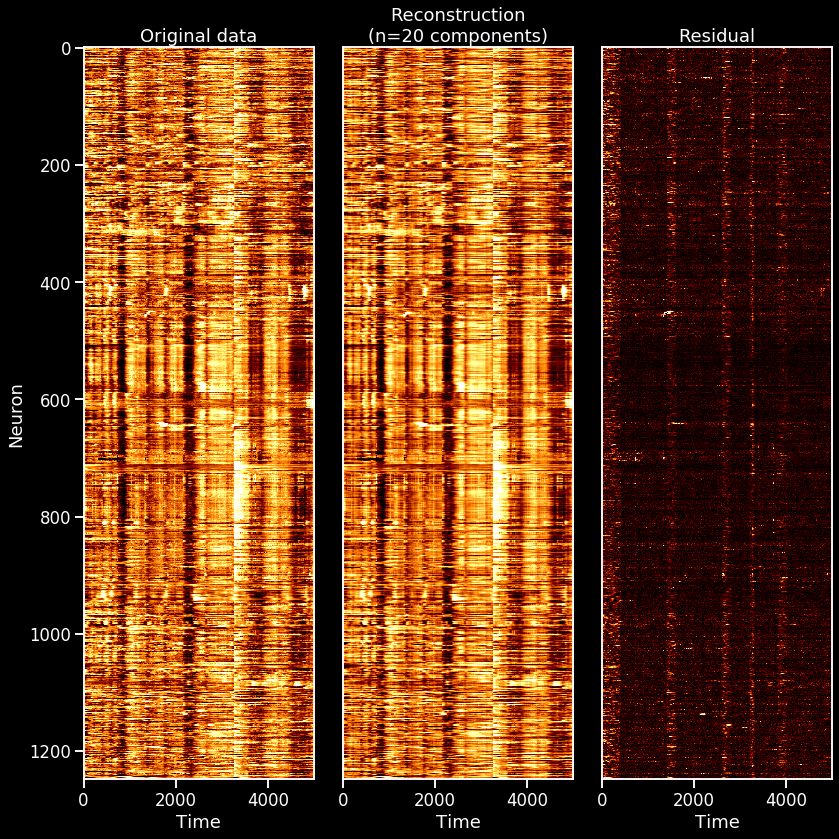

In [37]:
data_neural_recon = pca.inverse_transform(pca.transform(data_neural))
fig = plot_reconstruction(data_neural, data_neural_recon, n_components=n_components)

# 2. ICA on PCs

In [9]:
from sklearn.decomposition import FastICA

fit_on_pcs = False

n_components = 20
ica = FastICA(n_components=n_components)

if fit_on_pcs:
    ica.fit(pca.transform(data['train_all']))
    ics = ica.transform(pca.transform(data_neural))
    data_neural_recon_ica = pca.inverse_transform(ica.inverse_transform(ics))
else:
    ica.fit(data['train_all'])
    ics = ica.transform(data_neural)
    data_neural_recon_ica = ica.inverse_transform(ics)

ics = zscore(ics)

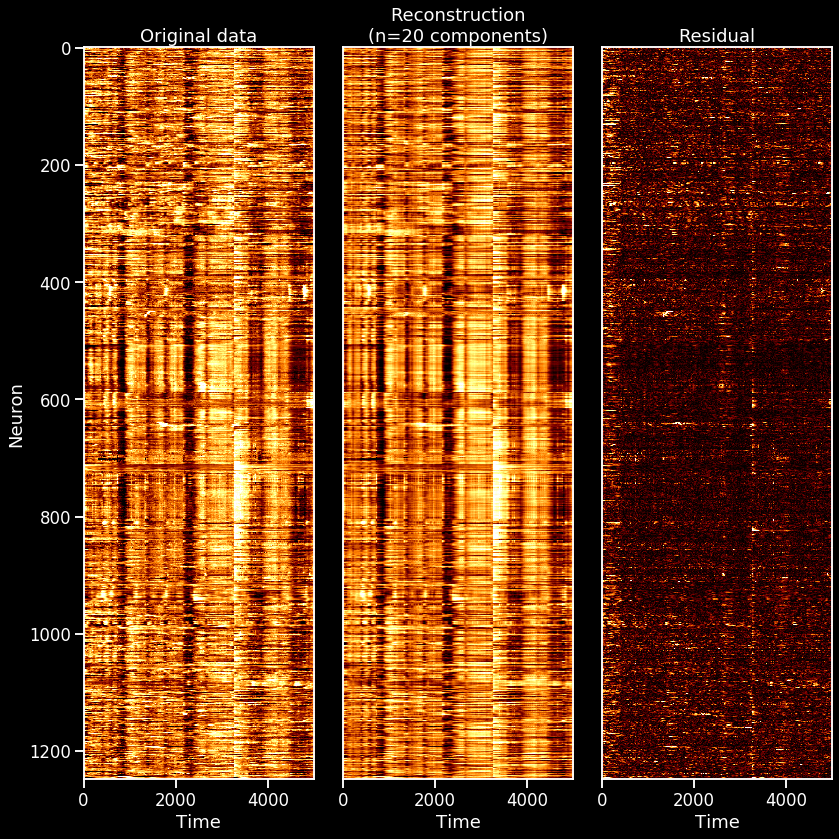

In [38]:
fig = plot_reconstruction(data_neural, data_neural_recon_ica, n_components=n_components)

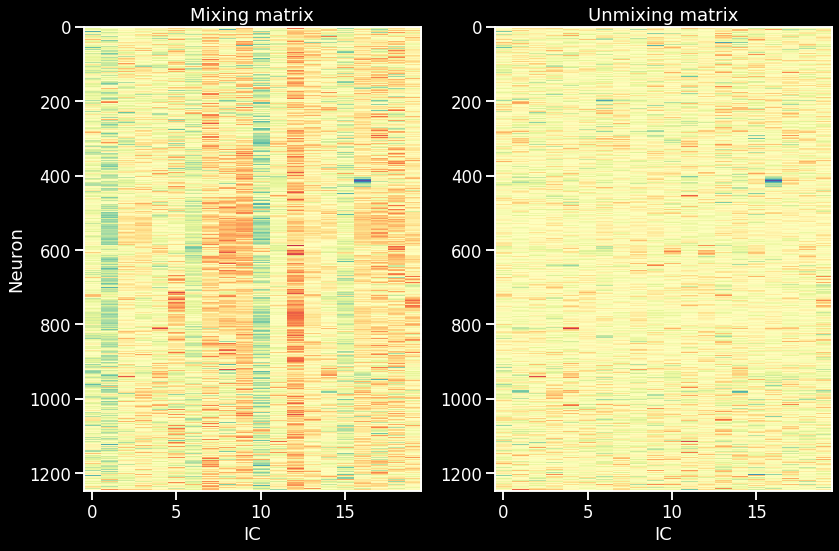

In [11]:
# plot mixing/unmixing matrices
cmap = 'Spectral'
plt.figure(figsize=(12, 8))

plt.subplot(121)
cmax = np.max(np.abs(ica.mixing_))
plt.imshow(ica.mixing_, aspect='auto', vmin=-cmax, vmax=cmax, cmap=cmap)
plt.xlabel('IC')
plt.ylabel('Neuron')
plt.title('Mixing matrix')

plt.subplot(122)
cmax = np.max(np.abs(ica.components_))
plt.imshow(ica.components_.T, aspect='auto', vmin=-cmax, vmax=cmax, cmap=cmap)
plt.xlabel('IC')
plt.title('Unmixing matrix')

plt.tight_layout()
plt.show()

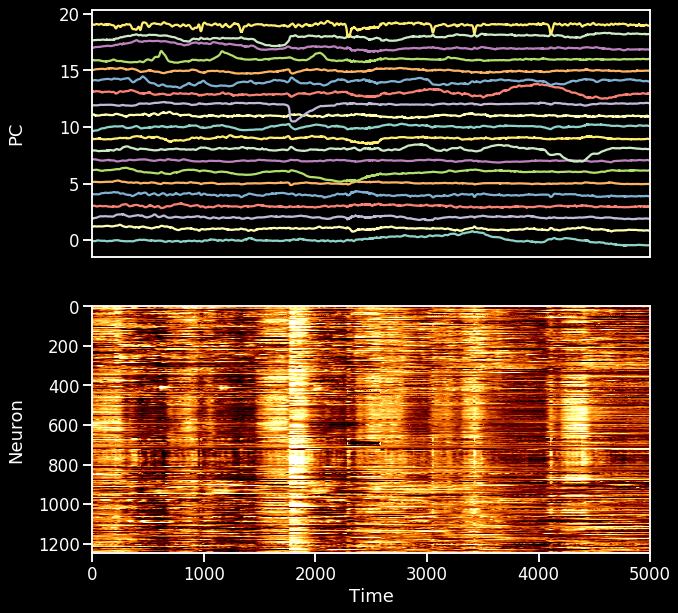

In [12]:
fig = plotting.plot_neural_activity(
    neural_data=data_neural, pcs=ics, slc=(5000, 10000), cmap_rasters=cmap_rasters)

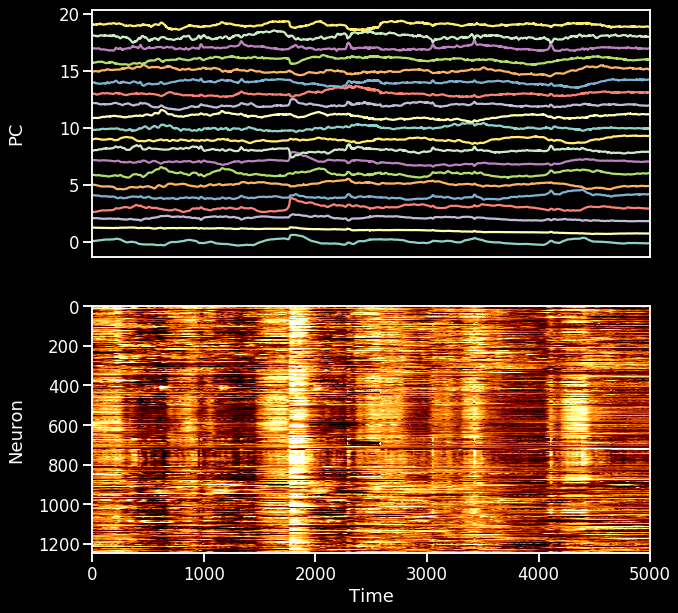

In [13]:
# plot PCs over time
pcs = pca.transform(data_neural)
pcs = zscore(pcs)
fig = plotting.plot_neural_activity(
    neural_data=data_neural, pcs=pcs[:, :20], slc=(5000, 10000), cmap_rasters=cmap_rasters)

### plot spatial footprint of ICs

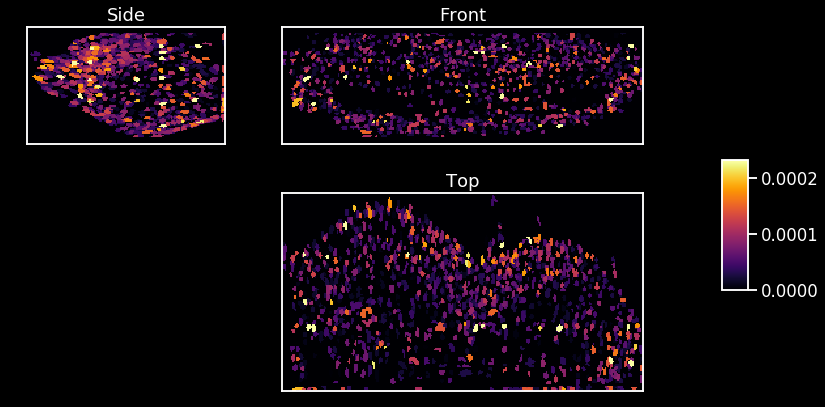

In [28]:
i = 2
Ar = A * np.abs(ica.components_[i, :])
dims = np.squeeze(data_dict['dims'])
R = np.reshape(Ar, dims, order='F')

fig, axes = plt.subplots(
    2, 2, gridspec_kw={
        'width_ratios': [dims[2]/dims[1], 1],
        'height_ratios':[dims[0]/dims[2], 1]},
    figsize=(12, 6))

vmax = np.quantile(np.abs(ica.components_[i, :]), 0.99)
vmin = 0 #-vmax
cmap = 'inferno'

im = axes[0, 0].imshow(np.max(R, axis=1), vmin=vmin, vmax=vmax, cmap=cmap)
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_title('Side')

axes[0, 1].imshow(np.max(R, axis=2), vmin=vmin, vmax=vmax, cmap=cmap)
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_title('Front')

axes[1, 1].imshow(np.max(R, axis=0).T, vmin=vmin, vmax=vmax, cmap=cmap)
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
axes[1, 1].set_title('Top')

axes[1, 0].set_axis_off()

plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.show()

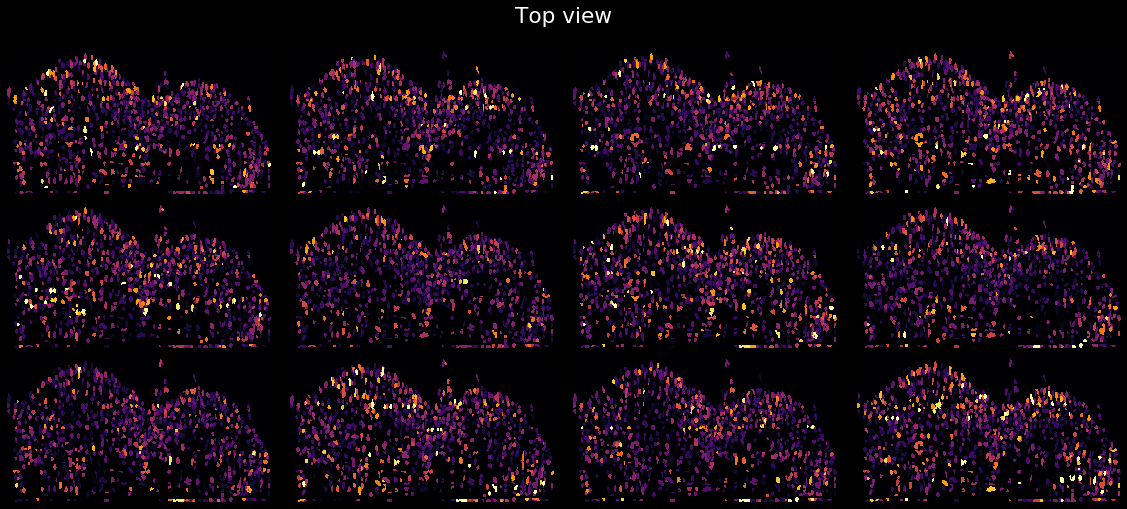

In [27]:
n_comps = 12
view = 'top'
add_colorbar = False

vmax = np.quantile(np.abs(ica.components_), 0.99)
vmin = 0 #-vmax
cmap = 'inferno'

n_cols = 4
n_rows = int(np.ceil(n_comps / n_cols))
    
k = 4
fig_width = k * n_cols
if view == 'top':
    fig_height = k * dims[1] / dims[2]
    max_ax = 0
    title_str = 'Top view'
elif view == 'side':
    fig_height = k * dims[2] / dims[0]
    max_ax = 1
    title_str = 'Side view'
elif view == 'front':
    fig_height = k * dims[1] / dims[0]
    max_ax = 2
    title_str = 'Front view'
    
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    
if len(axes.shape) == 1:
    axes = axes[None, :]
for ax1 in axes:
    for ax2 in ax1:
        ax2.set_axis_off()
    
dims = np.squeeze(data_dict['dims'])
for n in range(n_comps):
    
    r = int(np.floor(n / n_cols))
    c = n % n_cols
    
    Ar = A * np.abs(ica.components_[n, :])
    R = np.reshape(Ar, dims, order='F')

    if view == 'top':
        im = axes[r, c].imshow(np.max(R, axis=max_ax).T, vmin=vmin, vmax=vmax, cmap=cmap)
    else:
        im = axes[r, c].imshow(np.max(R, axis=max_ax), vmin=vmin, vmax=vmax, cmap=cmap)
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])

plt.tight_layout()
if add_colorbar:
    fr = 0.85
    fig.subplots_adjust(right=fr, top=fr)
    cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.3])
    fig.colorbar(im, cax=cbar_ax)
else:
    fr = 0.9
    fig.subplots_adjust(top=fr)
fig.suptitle(title_str)
plt.show()

# 3. Regress ICs onto neural activity

In [16]:
# from sklearn.linear_model import Ridge, LinearRegression
# from sklearn.metrics import r2_score

# # fit regression one cell at a time
# n_cells = data_neural.shape[1]
# r2s_trn = np.full(shape=(n_cells,), fill_value=np.nan)
# r2s_val = np.full(shape=(n_cells,), fill_value=np.nan)

# # split ICs into train/test/val


# for c in range(n_cells):
#     model = Ridge(alpha=1e-5, normalize=True)
#     target = {
#         'train_all': data['train_all'][:, c],
#         'val_all': data['val_all'][:, c]}
#     model.fit(predictors['train_all'], target['train_all'])
#     # evaluate on training data
#     recon = model.predict(predictors['train_all'])
#     r2s_trn[c] = r2_score(target['train_all'], recon)
#     # evaluate on validation data
#     recon = model.predict(predictors['val_all'])
#     r2s_val[c] = r2_score(target['val_all'], recon)

In [17]:
# fig = plot_behavior_predictions(run_lag, reg.predict(data_pca_lag_))

In [18]:
# fig = plot_behavior_predictions(
#     run_lag['val_all'], reg.predict(data_pca_lag['val_all']))